# Raspberry Pi 5 Power Analysis (CPU2)
This notebook analyzes Raspberry Pi (on-board PMIC) vs Siglent logs for CPU2 sweep.

Steps:
- Automatic detection of timestamp & power columns
- Fallback to sample index if Siglent has no timestamp
- Per-window averages (20s idle + 80s load)
- Error calculations (absolute + relative)
- Bar charts, scatter plots with regression
- Correlation at 0.5s and 1s bins

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [2]:
# --- File paths ---
pi_file = "energy_log_cpu2-00-10-20-30--100-annotated.csv"
siglent_file = "siglent-cpu2-00-10-20-30--100-annotated.csv"


In [3]:
def load_logs(pi_file, siglent_file):
    # Load Pi log
    pi = pd.read_csv(pi_file, sep=";", decimal=",", engine="python")
    ts_cols_pi = [c for c in pi.columns if "Timestamp" in c or "Date" in c]
    power_cols_pi = [c for c in pi.columns if "power" in c.lower()]
    ts_col_pi = ts_cols_pi[0]
    power_col_pi = power_cols_pi[0]
    try:
        pi["time"] = pd.to_datetime(pi[ts_col_pi], format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")
    except Exception:
        pi["time"] = pd.to_datetime(pi[ts_col_pi], errors="coerce")
    pi["power_pi"] = pd.to_numeric(pi[power_col_pi], errors="coerce")
    pi = pi.dropna(subset=["time"]).sort_values("time")
    
    # Load Siglent log
    sig = pd.read_csv(siglent_file, sep=";", decimal=",", engine="python")
    ts_cols_sig = [c for c in sig.columns if "Timestamp" in c or "Date" in c]
    if len(ts_cols_sig) > 0:
        ts_col_sig = ts_cols_sig[0]
        try:
            sig["time"] = pd.to_datetime(sig[ts_col_sig], format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")
        except Exception:
            sig["time"] = pd.to_datetime(sig[ts_col_sig], errors="coerce")
    else:
        sig["time"] = pd.RangeIndex(start=0, stop=len(sig), step=1)
    power_cols_sig = [c for c in sig.columns if "power" in c.lower()]
    if len(power_cols_sig) == 0:
        raise ValueError("No power column found in Siglent file!")
    power_col_sig = power_cols_sig[0]
    sig["power_sig"] = pd.to_numeric(sig[power_col_sig], errors="coerce")
    sig = sig.dropna(subset=["power_sig"]).sort_values("time")
    
    return pi, sig

def analyze(pi, sig, outdir):
    outdir = Path(outdir)
    outdir.mkdir(exist_ok=True)
    
    pi_rate = 10
    window_idle = 20 * pi_rate
    window_load = 80 * pi_rate
    
    segments = []
    loads = [0,10,20,30,40,50,60,70,80,90,100]
    idx = 0
    for load in loads:
        seg_pi_idle = pi.iloc[idx:idx+window_idle]
        seg_sig_idle = sig.iloc[int(idx/5):int((idx+window_idle)/5)]
        segments.append((load, "idle", seg_pi_idle["power_pi"].mean(), seg_sig_idle["power_sig"].mean()))
        idx += window_idle
        
        seg_pi_load = pi.iloc[idx:idx+window_load]
        seg_sig_load = sig.iloc[int(idx/5):int((idx+window_load)/5)]
        segments.append((load, "load", seg_pi_load["power_pi"].mean(), seg_sig_load["power_sig"].mean()))
        idx += window_load
    
    df_summary = pd.DataFrame(segments, columns=["cpuload","phase","mean_pi","mean_siglent"])
    df_summary["abs_error_W"] = df_summary["mean_pi"] - df_summary["mean_siglent"]
    df_summary["rel_error_%"] = 100 * df_summary["abs_error_W"] / df_summary["mean_siglent"]
    df_summary.to_csv(outdir/"summary.csv", index=False)
    
    # Bar chart
    plt.figure(figsize=(10,6))
    bar_labels = [f"{l}-{p}" for l,p in zip(df_summary["cpuload"], df_summary["phase"])]
    plt.bar(bar_labels, df_summary["mean_pi"], alpha=0.7, label="Pi", color="orange")
    plt.bar(bar_labels, df_summary["mean_siglent"], alpha=0.7, label="Siglent", color="blue")
    plt.xticks(rotation=90)
    plt.ylabel("Mean Power (W)")
    plt.title("Mean Power by Load (Pi vs Siglent)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outdir/"mean_power_bar.png")
    plt.show()
    
    # Scatter + regression
    x = df_summary["mean_pi"].values
    y = df_summary["mean_siglent"].values
    mask = (~np.isnan(x)) & (~np.isnan(y)) & np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    if len(x) > 1:
        slope, intercept = np.polyfit(x,y,1)
        plt.figure(figsize=(6,6))
        plt.scatter(x,y,c="purple",label="Windows")
        plt.plot([x.min(),x.max()],[slope*x.min()+intercept, slope*x.max()+intercept],
                 color="red",label=f"y={slope:.2f}x+{intercept:.2f}")
        plt.xlabel("Pi Mean Power (W)")
        plt.ylabel("Siglent Mean Power (W)")
        plt.title("Pi vs Siglent (per window means)")
        plt.legend()
        plt.grid(True)
        plt.savefig(outdir/"scatter_regression.png")
        plt.show()
    
    return df_summary

def align_by_index(pi, sig, bin_size_s=0.5):
    samples_per_bin_pi = int(round(bin_size_s / 0.1))
    pi_vals = [pi["power_pi"].values[i:i+samples_per_bin_pi].mean()
               for i in range(0, len(pi), samples_per_bin_pi)]
    samples_per_bin_sig = int(round(bin_size_s / 0.5))
    sig_vals = [sig["power_sig"].values[i:i+samples_per_bin_sig].mean()
                for i in range(0, len(sig), samples_per_bin_sig)]
    n = min(len(pi_vals), len(sig_vals))
    pi_vals, sig_vals = pi_vals[:n], sig_vals[:n]
    df = pd.DataFrame({"pi": pi_vals, "sig": sig_vals})
    r = df.corr().iloc[0,1]
    return df, r


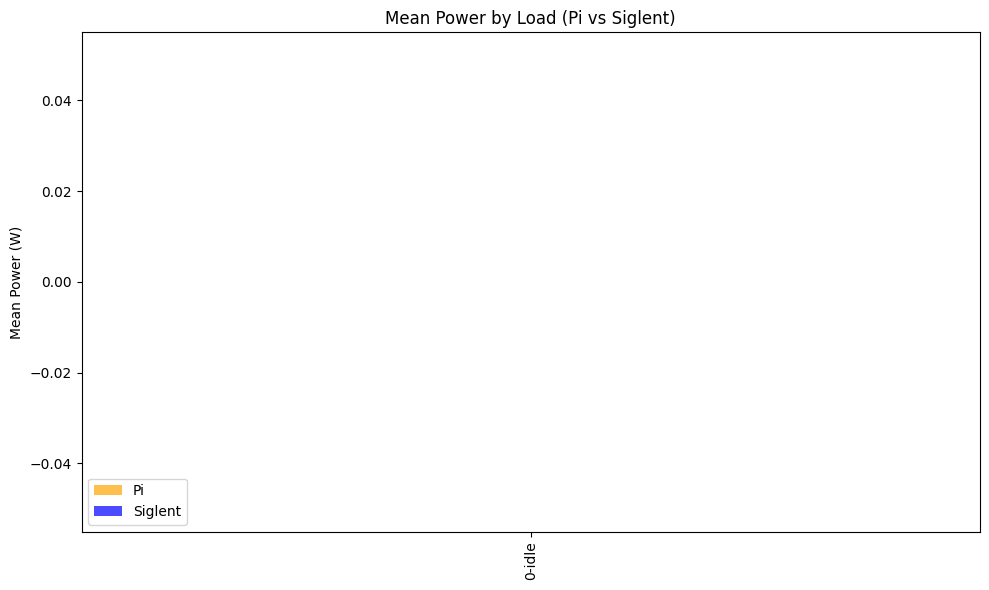

CPU2 correlation (0.5s): nan
CPU2 correlation (1s): nan


In [4]:
# --- Run analysis for CPU2 ---
pi, sig = load_logs(pi_file, siglent_file)
df_summary = analyze(pi, sig, "analysis_cpu2_sweep")
df_corr_05, r05 = align_by_index(pi, sig, 0.5)
df_corr_1s, r1s = align_by_index(pi, sig, 1.0)
print("CPU2 correlation (0.5s):", r05)
print("CPU2 correlation (1s):", r1s)
